In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# Human Node 추가 

- 앞선 파일에서는 도구가 호출될 때마다 interrupt 통해 그래프 중단되도록 구현 
- 이번 파일에서는 챗봇이 인간에 의존할지 선택할 수 있도록 하는 노드로 구성 (Human Node) 

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # 사람에게 질문할지 여부를 묻는 상태 추가
    ask_human: bool

[참고]
BaseModel : pydantic 라이브러리에서 제공하는 클래스로 구조화된 데이터(eg, JSON, 사용자 입력 등)를 정해진 형식대로 검증하고 자동 반환해 주는 역할 

In [6]:
class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

In [8]:
# TOOLS
tool = TavilySearch(max_results=3)
tools = [tool, HumanRequest]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest' 인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 반환
    return {"messages": [response], "ask_human": ask_human}

In [9]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

`human` 노드

- 이 노드는 주로 그래프에서 interrupt를 트리거하는 자리 표시자 역할
- 사용자가 `interrupt` 동안 수동으로 상태를 업데이트하지 않으면, LLM이 사용자가 요청을 받았지만 응답하지 않았음을 알 수 있도록 도구 메시지 삽입
- 이 노드는 또한 `ask_human` 플래그를 해제하여 추가 요청이 없는 한 그래프가 노드를 다시 방문하지 않도록 설계함

In [10]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 휴먼 노드 정의
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages, # 새 메시지 추가
        "ask_human": False,  # 플래그 해제
    }


# 그래프에 휴먼 노드 추가
graph_builder.add_node("human", human_node)

조건부 논리는...

- `select_next_node` : 플래그가 설정된 경우 `human` 노드로 경로 지정. 그렇지 않으면, 사전 구축된 `tools_condition` 함수가 다음 노드를 선택하도록 함
- `tools_condition` 함수는 단순히 `chatbot`이 응답 메시지에서 `tool_calls`을 사용했는지 확인
- 사용한 경우, `action` 노드로 경로 지정. 그렇지 않으면, 그래프 종료

In [11]:
from langgraph.graph import END

In [12]:
# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# Conditional Edge
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [13]:
# EDGE
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

# MEMORY
memory = MemorySaver()

# COMPILE
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"], # 'human' 이전에 인터럽트 설정
)

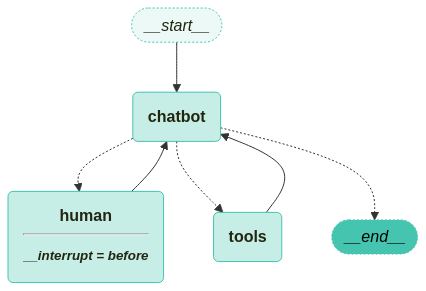

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

**그래프 해석**

- __start__ → chatbot          : 실선 (기본 흐름)
- chatbot   → __end__          : 점선 (조건부 분기: 도구 호출 불필요 시 종료)
- chatbot   → tools            : 점선 (조건부 분기: 도구 호출 필요 시 실행)
- tools     → chatbot          : 실선 (기본 흐름: 도구 실행 후 응답을 위해 복귀)
- (human interrupt) → chatbot  : chatbot 실행 전에 human node 개입 

In [15]:
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

config = {"configurable": {"thread_id": "001"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_7qYqwmbLruPadHjpHDoJYXVl)
 Call ID: call_7qYqwmbLruPadHjpHDoJYXVl
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다.


In [16]:
# LLM은 HumanRequest 도구를 호출하면서 인터럽트 설정 
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next

('human',)

In [17]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '001',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00b8b5-17f8-61d4-8002-f1b51940bf7a'}}

In [ ]:
# 그래프 상태에서 메시지
graph.get_state(config).values["messages"]

[HumanMessage(content='이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?', additional_kwargs={}, response_metadata={}, id='bbf5fe22-0938-4a1c-b36f-fa873f976d8e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7qYqwmbLruPadHjpHDoJYXVl', 'function': {'arguments': '{"request":"AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다."}', 'name': 'HumanRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 171, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-15115045-1592-4058-bbff-16f8420e8424-0', tool_calls=[{'name': 'HumanRequest', 'args': {

In [19]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가의 도움을 받았습니다! AI 에이전트를 구축하기 위해 LangGraph를 사용하는 것을 추천드립니다. 이 방법은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다. 도움이 필요하시면 언제든지 말씀해 주세요!


In [20]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_7qYqwmbLruPadHjpHDoJYXVl)
 Call ID: call_7qYqwmbLruPadHjpHDoJYXVl
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가의 도움을 받았습니다! AI 에이전트를 구축하기 위해 LangGraph를 사용하는 것을 추천드립니다. 이 방법은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다. 도움이 필요하시면 언제든지 말씀해 주세요!


-----
** End of Documents **